# Example Q2 - Variational quantum eigensolver

This example demonstrates the principle of a variational quantum eigensolver (VQE), originally proposed in [Peruzzo et al. (2014)](https://www.nature.com/articles/ncomms5213). To showcase the hybrid computational capabilities of PennyLane, we first train a quantum circuit to minimize the squared energy expectation for a Hamiltonian $H$, 

$$ \langle \psi_v | H | \psi_v \rangle^2  =( 0.1 \langle \psi_{v} | X_2 | \psi_v \rangle + 0.5 \langle \psi_v | Y_2 | \psi_v \rangle )^2.  $$

Here, $| \psi_v \rangle $ is the state obtained after applying a quantum circuit to an initial state $|0\rangle$. The quantum circuit depends on trainable variables $v = \{v_1, v_2\}$, and $X_2$, $Y_2$ denote the Pauli-X and Pauli-Y operator acting on the second qubit (*Note: We apply the square to make the optimization landscapes more interesting, but in common applications the cost is directly the energy expectation value*).

After doing this, we will then turn things around and use a fixed quantum circuit to prepare a state $| \psi \rangle $, but train the coefficients of the Hamiltonian to minimize

$$ \langle \psi | H | \psi \rangle^2  = (v_1 \langle \psi | X_2 | \psi \rangle + v_2 \langle \psi | Y_2 | \psi \rangle )^2 . $$


## 1. Optimizing the quantum circuit

### Imports

We begin by importing PennyLane, the PennyLane-wrapped version of NumPy, and the GradientDescentOptimizer.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer

We use the default qubit simulator as a device.

In [2]:
dev = qml.device('default.qubit', wires=2)

### Quantum nodes

The quantum circuit of the variational eigensolver is an ansatz that defines a manifold of possible quantum states. We use a Hadamard, two rotations and a CNOT gate to construct our circuit. 

In [3]:
def ansatz(var):

    qml.Rot(0.3, 1.8, 5.4, wires=1)
    qml.RX(var[0], wires=0)
    qml.RY(var[1], wires=1)
    qml.CNOT(wires=[0, 1])

A variational eigensolver requires us to evaluate expectations of different Pauli operators. In this example, the Hamiltonian is expressed by only two single-qubit Pauli operators, namely the X and Y operator applied to the first qubit. 

Since these operators will be measured on the same wire, we will need to create two quantum nodes (one for each operator whose expectation value we measure), but we can reuse the same device. 

*NOTE: If the Pauli observables were evaluated on different wires, we could use one quantum node and return a tuple of expectations in only one quantum node: `return qml.expectation.PauliX(0), qml.expectation.PauliY(1)`*

In [4]:
@qml.qnode(dev)
def circuit_X(var):
    ansatz(var)
    return qml.expval.PauliX(1)


@qml.qnode(dev)
def circuit_Y(var):
    ansatz(var)
    return qml.expval.PauliY(1)

### Objective

The cost function to be optimized in VQE is simply a linear combination of the expectations, which defines the expectation of the Hamiltonian we are interested in. In our case, we square this cost function to provide a more interesting landscape with the same minima.

In [5]:
def cost(var):

    expX = circuit_X(var)
    expY = circuit_Y(var)

    return (0.1 * expX + 0.5 * expY) ** 2

This cost defines the following landscape:

*Note: To run the following cell you need the matplotlib library.*

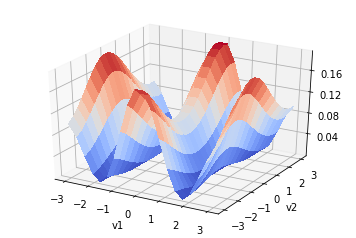

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3., 3., 20)
Y = np.linspace(-3., 3., 20)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[cost([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.show()

### Optimization

We create a GradientDescentOptimizer and use it to optimize the cost function.

In [7]:
opt = GradientDescentOptimizer(0.5)

var = [0.3, 2.5]
var_gd = [var]
for it in range(20):
    var = opt.step(cost, var)
    var_gd.append(var)

    print('Cost after step {:5d}: {: .7f} | Variables: [{: .5f},{: .5f}]'
          .format(it+1, cost(var), var[0], var[1]) )

Cost after step     1:  0.1737355 | Variables: [ 0.34699, 2.49206]
Cost after step     2:  0.1675543 | Variables: [ 0.40033, 2.48402]
Cost after step     3:  0.1598003 | Variables: [ 0.46035, 2.47592]
Cost after step     4:  0.1502869 | Variables: [ 0.52718, 2.46780]
Cost after step     5:  0.1389376 | Variables: [ 0.60056, 2.45973]
Cost after step     6:  0.1258558 | Variables: [ 0.67982, 2.45179]
Cost after step     7:  0.1113782 | Variables: [ 0.76374, 2.44405]
Cost after step     8:  0.0960798 | Variables: [ 0.85059, 2.43661]
Cost after step     9:  0.0807058 | Variables: [ 0.93826, 2.42956]
Cost after step    10:  0.0660363 | Variables: [ 1.02448, 2.42297]
Cost after step    11:  0.0527307 | Variables: [ 1.10710, 2.41691]
Cost after step    12:  0.0412146 | Variables: [ 1.18438, 2.41141]
Cost after step    13:  0.0316476 | Variables: [ 1.25514, 2.40648]
Cost after step    14:  0.0239656 | Variables: [ 1.31877, 2.40210]
Cost after step    15:  0.0179609 | Variables: [ 1.37518, 2.39

We can plot the path that the variables took during gradient descent. To make the plot more clear, we will shorten the range for $v_2$.

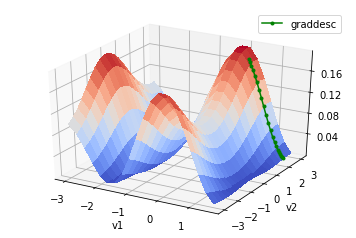

In [8]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, np.pi/2, 20)
Y = np.linspace(-3, 3, 20)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[cost([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [cost(var)+1e-8 for var in var_gd]
path_x = [v[0] for v in var_gd]
path_y = [v[1] for v in var_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

## 2. Optimizing the Hamiltonian coefficients

Instead of optimizing the circuit parameters, we can also use a fixed circuit,

In [9]:
def ansatz():

    qml.Rot(0.3, 1.8, 5.4, wires=1)
    qml.RX(-0.5, wires=0)
    qml.RY( 0.5, wires=1)
    qml.CNOT(wires=[0, 1])
    
    
@qml.qnode(dev)
def circuit_X():
    ansatz()
    return qml.expval.PauliX(1)


@qml.qnode(dev)
def circuit_Y():
    ansatz()
    return qml.expval.PauliY(1)

and make the classical coefficients that appear in the Hamiltonian the trainable variables.

In [10]:
def cost(var):

    expX = circuit_X()
    expY = circuit_Y()

    return (var[0] * expX + var[1] * expY) ** 2

In [11]:
opt = GradientDescentOptimizer(0.5)

var = [0.3, 2.5]
var_gd = [var]
for it in range(20):
    var = opt.step(cost, var)
    var_gd.append(var)

    print('Cost after step {:5d}: {: .7f} | Variables: [{: .5f},{: .5f}]'
          .format(it+1, cost(var), var[0], var[1]) )

Cost after step     1:  0.3269168 | Variables: [ 0.95937, 1.49547]
Cost after step     2:  0.0461959 | Variables: [ 1.20723, 1.11786]
Cost after step     3:  0.0065278 | Variables: [ 1.30040, 0.97591]
Cost after step     4:  0.0009224 | Variables: [ 1.33543, 0.92255]
Cost after step     5:  0.0001303 | Variables: [ 1.34859, 0.90250]
Cost after step     6:  0.0000184 | Variables: [ 1.35354, 0.89496]
Cost after step     7:  0.0000026 | Variables: [ 1.35540, 0.89212]
Cost after step     8:  0.0000004 | Variables: [ 1.35610, 0.89106]
Cost after step     9:  0.0000001 | Variables: [ 1.35636, 0.89066]
Cost after step    10:  0.0000000 | Variables: [ 1.35646, 0.89051]
Cost after step    11:  0.0000000 | Variables: [ 1.35650, 0.89045]
Cost after step    12:  0.0000000 | Variables: [ 1.35651, 0.89043]
Cost after step    13:  0.0000000 | Variables: [ 1.35652, 0.89042]
Cost after step    14:  0.0000000 | Variables: [ 1.35652, 0.89042]
Cost after step    15:  0.0000000 | Variables: [ 1.35652, 0.89

The landscape has a quadratic shape.

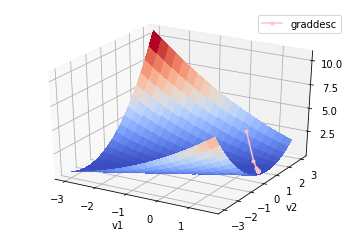

In [12]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, np.pi/2, 20)
Y = np.linspace(-3, 3, 20)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[cost([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [cost(var)+1e-8 for var in var_gd]
path_x = [v[0] for v in var_gd]
path_y = [v[1] for v in var_gd]
ax.plot(path_x, path_y, path_z, c='pink', marker='.', label="graddesc")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

## 3. Optimizing classical and quantum parameters

Finally, we can optimize *classical* and *quantum* weights together by combining the two approaches from above.

In [13]:
def ansatz(var):

    qml.Rot(0.3, 1.8, 5.4, wires=1)
    qml.RX(var[0], wires=0)
    qml.RY(var[1], wires=1)
    qml.CNOT([0, 1])


@qml.qnode(dev)
def circuit_X(var):
    ansatz(var)
    return qml.expval.PauliX(1)


@qml.qnode(dev)
def circuit_Y(var):
    ansatz(var)
    return qml.expval.PauliY(1)


def cost(var):

    expX = circuit_X(var)
    expY = circuit_Y(var)

    return (var[2] * expX + var[3] * expY) ** 2


opt = GradientDescentOptimizer(0.5)

var = [0.3, 2.5, 0.3, 2.5]

for it in range(10):
    var = opt.step(cost, var)
    
    print('Cost after step {:5d}: {: 0.7f}'.format(it+1, cost(var)))


Cost after step     1:  0.1978826
Cost after step     2:  0.0008013
Cost after step     3:  0.0000028
Cost after step     4:  0.0000000
Cost after step     5:  0.0000000
Cost after step     6:  0.0000000
Cost after step     7:  0.0000000
Cost after step     8:  0.0000000
Cost after step     9:  0.0000000
Cost after step    10:  0.0000000
